In [14]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [15]:
imagedir = "Datasets/Detection/Byteplots"

In [16]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...
Images processed: 3931


In [17]:
X.shape

(3931, 224, 224, 3)

In [18]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = Xception(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [19]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [20]:
bnfeatures.shape

(3931, 2048)

In [21]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [22]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, ga

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.4min


[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505718, total= 1.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total= 1.9min
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.6min


[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 2.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total= 2.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505718, total= 2.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505718, total= 2.0min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total= 2.0min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 2.0min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total= 2.0min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.7min


[CV] ............... C=0.01, gamma=0.01, score=0.848793, total= 1.5min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.851145, total= 1.5min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.852417, total= 1.5min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.882952, total= 1.5min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.849873, total= 1.5min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.645038, total= 1.9min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.2min


[CV] ................ C=0.01, gamma=0.1, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total= 2.0min
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total= 2.1min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505718, total= 2.1min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  9.6min


[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505718, total= 1.9min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 10.9min


[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.712834, total= 2.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.692112, total= 2.1min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 12.5min


[CV] ............... C=0.1, gamma=0.001, score=0.875318, total= 1.2min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.725191, total= 1.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.730280, total= 1.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.697201, total= 1.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.776081, total= 1.7min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.773825, total= 1.8min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.790076, total= 1.8min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 15.3min


[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 2.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 2.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505718, total= 2.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total= 2.0min
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 2.1min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.505718, total= 1.9min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total= 1.9min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 17.4min


[CV] .............. C=1.0, gamma=0.0001, score=0.878018, total= 1.2min
[CV] C=1.0, gamma=0.1 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.868957, total= 1.3min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.956798, total=  35.6s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-07, score=0.505089, total= 2.1min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.871501, total= 1.2min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.950382, total=  34.4s
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.904580, total= 1.3min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 18.3min


[CV] ............... C=1.0, gamma=1e-05, score=0.697201, total= 2.1min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.726463, total= 2.1min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.910941, total= 1.5min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.891995, total= 1.7min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.907125, total= 1.7min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.894402, total= 1.7min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.879135, total= 1.7min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 21.4min


[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total= 1.7min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total= 1.7min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.505718, total= 1.8min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.505089, total= 1.7min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.505089, total= 1.8min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.505089, total= 1.8min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total= 1.9min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 22.7min


[CV] ............... C=10.0, gamma=0.01, score=0.978372, total=  35.4s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.904580, total= 1.1min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.871501, total= 1.1min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.505089, total= 1.7min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=0.01, score=0.952926, total=  29.1s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=0.01, score=0.954198, total=  29.2s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.879135, total= 1.2min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 25.3min


[CV] ............... C=10.0, gamma=10.0, score=0.578880, total= 1.4min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.505718, total= 1.4min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=0.1, score=0.884224, total= 2.0min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.606099, total= 2.0min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.628499, total= 1.9min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 26.8min


[CV] ............ C=100.0, gamma=0.0001, score=0.940204, total=  28.9s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.932570, total=  28.3s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=0.001, score=0.965693, total=  28.9s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.871501, total=  52.1s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=0.001, score=0.952926, total=  21.9s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=0.001, score=0.970738, total=  22.7s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.879135, total=  52.4s
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 29.1min


[CV] .............. C=100.0, gamma=10.0, score=0.567430, total= 1.3min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.562341, total= 1.3min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.562897, total= 1.4min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.910941, total= 1.7min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.904580, total= 1.2min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.699746, total= 1.3min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ............... C=100.0, gamma=0.1, score=0.917303, total= 1.7min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed: 30.8min remaining:  1.7min


[CV] ............. C=1000.0, gamma=0.01, score=0.977099, total=  25.6s
[CV] .............. C=1000.0, gamma=0.1, score=0.899491, total=  56.6s
[CV] .............. C=1000.0, gamma=0.1, score=0.917303, total=  57.2s
[CV] .............. C=1000.0, gamma=0.1, score=0.910941, total=  57.7s
[CV] .............. C=1000.0, gamma=0.1, score=0.897078, total= 1.1min
[CV] ............. C=1000.0, gamma=10.0, score=0.562897, total=  59.7s
[CV] ............. C=1000.0, gamma=10.0, score=0.567430, total= 1.0min
[CV] .............. C=1000.0, gamma=0.1, score=0.884224, total= 1.6min
[CV] .............. C=1000.0, gamma=1.0, score=0.628499, total= 1.5min
[CV] ............. C=1000.0, gamma=10.0, score=0.578880, total= 1.4min
[CV] .............. C=1000.0, gamma=1.0, score=0.606099, total= 1.5min
[CV] .............. C=1000.0, gamma=1.0, score=0.627226, total= 1.5min
[CV] .............. C=1000.0, gamma=1.0, score=0.615776, total= 1.5min
[CV] ............. C=1000.0, gamma=10.0, score=0.567430, total= 1.5min
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 32.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [23]:
top_model.cv_results_

{'mean_fit_time': array([  96.11482935,   96.73521838,   93.78234797,   92.95604229,
          93.55130486,   91.00371518,   71.48599977,   96.42744484,
          97.99066319,   95.61234493,   90.35286975,   90.79054799,
          97.09886184,   97.71266761,   94.33291216,   58.58322725,
          40.96429677,   85.08990097,  100.53703794,   98.60364323,
          94.81957979,   92.22201285,  100.18319983,  102.9204854 ,
          59.54838181,   35.13629303,   28.46187582,   80.924016  ,
          91.80092931,   86.70736785,   86.72624283,   83.07717218,
          88.94978905,   51.38597722,   35.58974018,   22.29442296,
          24.7622252 ,   86.79830976,   86.04697294,   75.04303913,
          76.2302916 ,   78.36239758,   40.12891636,   27.86248817,
          21.16873598,   19.97264004,   22.50105858,   81.45390024,
          81.92941976,   74.79946699,   73.10996118,   46.34283905,
          23.00435576,   20.05040927,   19.0236268 ,   19.77127857,
          20.33415813,   57.977

In [24]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.66014, std: 0.01072, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.85703, std: 0.01301, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [25]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.01} - score: 0.9626


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


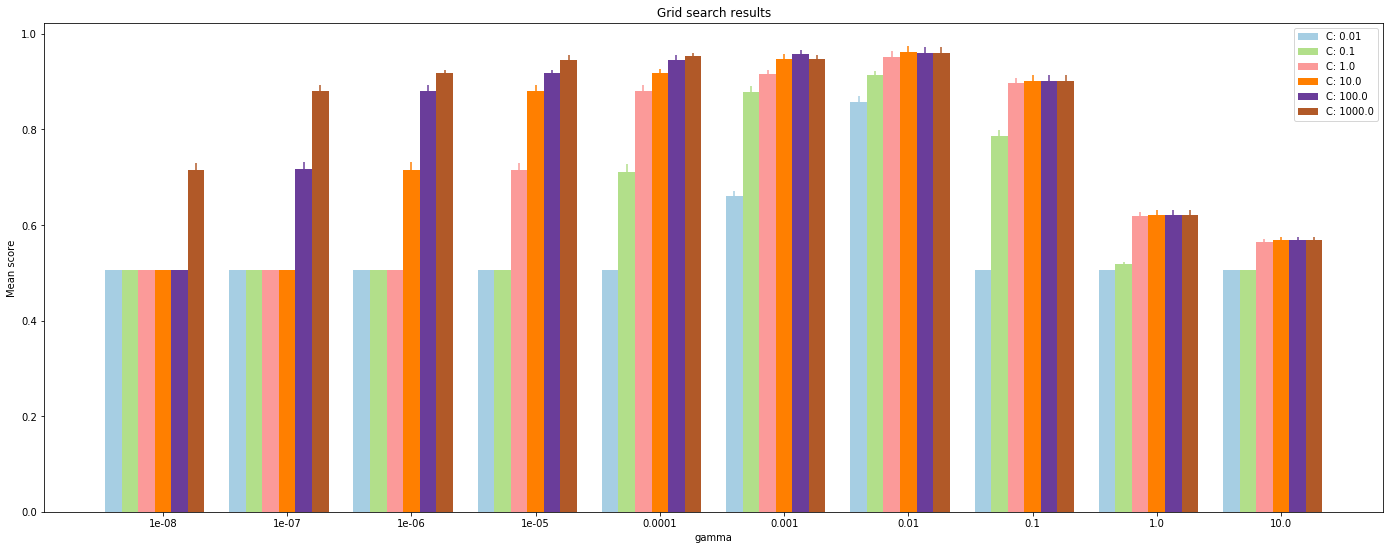

In [26]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()